In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from gensim.models import Word2Vec
import umap

import warnings;
warnings.filterwarnings('ignore')

# Reading Data

In [2]:
# Reading the data
df = pd.read_csv('transaction_data.csv')
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (1083818, 8)


In [3]:
# Checking sample data
df.head()

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
0,278166,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
4,-1,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom


In [4]:
# Checking datatypes and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083818 entries, 0 to 1083817
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   UserId                  1083818 non-null  int64  
 1   TransactionId           1083818 non-null  int64  
 2   TransactionTime         1083818 non-null  object 
 3   ItemCode                1083818 non-null  int64  
 4   ItemDescription         1080910 non-null  object 
 5   NumberOfItemsPurchased  1083818 non-null  int64  
 6   CostPerItem             1083818 non-null  float64
 7   Country                 1083818 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 66.2+ MB


# Data Cleaning

## 1) Removing Duplicate Entries

In [5]:
print('Duplicate data entries: {}'.format(df.duplicated().sum()))
df.drop_duplicates(inplace = True)
print('Dataframe dimensions after dropping duplicates:', df.shape)

Duplicate data entries: 547246
Dataframe dimensions after dropping duplicates: (536572, 8)


## 2) Processing Invalid Entries

### 2.1) UserId

In [6]:
missing_user_id = df[df['UserId'] <= 0].UserId.count()
print('Number of entries with missing UserId:', missing_user_id)

Number of entries with missing UserId: 135003


#### Entries with UserId <= 0:
* Assuming that the UserIds <= 0 imply that the actual Id is missing
* While finding the relationship between items bought, we can work with just the TransactionId, even if UserId is unavailable
* Thus, we will keep these entries as they are

### 2.2) TransactionId

In [7]:
missing_transaction_id = df[df['TransactionId'] <= 0].UserId.count()
print('Number of entries with missing TransactionId:', missing_transaction_id)

Number of entries with missing TransactionId: 0


### 2.3) ItemCode

In [8]:
missing_item_code = df[df['ItemCode'] <= 0].UserId.count()
print('Number of entries with missing ItemCode:', missing_item_code)

Number of entries with missing ItemCode: 2790


In [9]:
set(df[df['ItemCode'] <= 0]['ItemDescription'])

{'AMAZON FEE',
 'Adjust bad debt',
 'BOYS PARTY BAG',
 'Bank Charges',
 'CRUK Commission',
 'DOTCOM POSTAGE',
 'Discount',
 'GIRLS PARTY BAG',
 'Manual',
 'PADS TO MATCH ALL CUSHIONS',
 'POSTAGE',
 'SAMPLES',
 nan}

#### Entries with ItemCode -1:
* The description of items corresponding to code -1 is listed above
* They mostly refer to non-purchasable items, like Bank Charges, Postage, etc.
* Thus, we will be excluding these entries

In [10]:
df.drop(df[df['ItemCode'] <= 0].index, inplace = True)
print('Dataframe dimensions after removing these ItemCode:', df.shape)

Dataframe dimensions after removing these ItemCode: (533782, 8)


### 2.4) NumberOfItemsPurchased

In [11]:
missing_num_purch = df[df['NumberOfItemsPurchased'] <= 0].UserId.count()
print('Number of entries with negative quantity of Items purchased:', missing_num_purch)

Number of entries with negative quantity of Items purchased: 10005


#### Entries with NumberOfItemsPurchased <= 0:
* Assuming that these entries denote the items not purchased/returned/transaction anamoly
* So we will be excluding these entries

In [12]:
df.drop(df[df['NumberOfItemsPurchased'] <= 0].index, inplace = True)
print('Dataframe dimensions after dropping the items not purchased:', df.shape)

Dataframe dimensions after dropping the items not purchased: (523777, 8)


### 2.5) CostPerItem

In [13]:
missing_cost_per_item = df[df['CostPerItem'] < 0].UserId.count()
print('Number of entries with missing CostPerItem:', missing_cost_per_item)

Number of entries with missing CostPerItem: 0


### 2.6) ItemDecription

In [14]:
# Removing NaN entries from ItemDescription
df.dropna(subset=['ItemDescription'], inplace=True)
print('Dataframe dimensions after dropping the items with no description:', df.shape)

Dataframe dimensions after dropping the items with no description: (523190, 8)


# Data Preparation

In [15]:
df['ItemCode']= df['ItemCode'].astype(str)

In [16]:
# List of transactions
transactions = df['TransactionId'].unique().tolist()
print('Number of unique transactions:', len(transactions))

Number of unique transactions: 19958


In [17]:
# List of items purchased in each transaction
items_purchased = []

for i in transactions:
    temp = df[df['TransactionId'] == i]['ItemCode'].tolist()
    items_purchased.append(temp)

# Model Training

In [18]:
# Building Word2Vec model
model = Word2Vec(size = 50, window = 10, sg = 1, hs = 0, negative = 10, seed = 21)

model.build_vocab(items_purchased)

In [19]:
# Training the model
model.train(items_purchased, total_examples = model.corpus_count, epochs = 20)

(10359830, 10463800)

In [20]:
# Stopping the training
model.init_sims(replace=True)

In [21]:
# Saving the trained vectors
model_data = model[model.wv.vocab]
model_data.shape

(3043, 50)

# Visualization

In [22]:
# Applying dimensionality reduction on the vectors (projecting in 2D space)
cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=42).fit_transform(model_data)

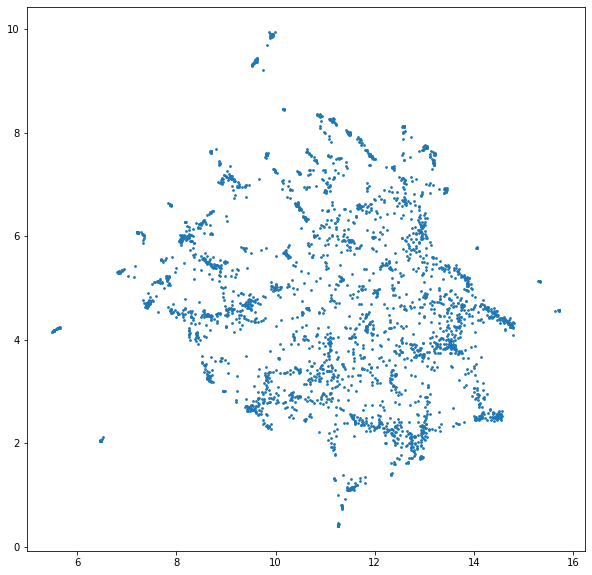

In [23]:
# Plotting
plt.figure(figsize=(10,10))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3)
plt.show()

#### Here the dots represent the vectors representing the items projected in a 2D plane

# Testing

In [24]:
items = df[['ItemCode', 'ItemDescription']]

# Removing duplicate copies of items
items.drop_duplicates(inplace=True, subset='ItemCode', keep='last')

# Creating ItemCode ItemDdescription dictionary
dict_items = items.groupby('ItemCode')['ItemDescription'].apply(list).to_dict()

In [25]:
def item_reco(item, mode=0):
    
    """ mode = 0: Enter the ItemCode to get the 2 recommended items along with the similarity score
        mode = 1: Return just the ItemCode as int, for the output file """
    
    data = model.similar_by_vector(model[item], topn=3)[1:]
    out = []

    if mode == 0:   
        for i in data:
            temp = (i[0], dict_items[i[0]][0], i[1])
            out.append(temp)
        
        print('ItemCode\t', 'ItemDescription\t', 'SimilarityScore\t')
    
        return out
    
    elif mode == 1:
        for i in data:
            out.append(i[0])
            
        return out

In [26]:
# Test example
# item_reco('465549')

# Output

In [27]:
target_item = []
items_reco1 = []
items_reco2 = []

for i in items['ItemCode']:
    try:
        target_item.append(int(i))
        temp = item_reco(i, mode=1)
        items_reco1.append(temp[0])
        items_reco2.append(temp[1])
    except KeyError:
        target_item.pop(-1)

In [28]:
df_output = pd.DataFrame(columns=['TargetItem', 'RecommendedItem1', 'RecommendedItem2'])
df_output['TargetItem'] = target_item
df_output['RecommendedItem1'] = items_reco1
df_output['RecommendedItem2'] = items_reco2

In [30]:
# Writing to csv file
# df_output.to_csv('results.csv')